# Spatial mapping of cell types across fetal lung (2/3) - cell2location

Author: Vitalii Kleshchevnikov

Project leader: Peng He, Kerstin Meyer 

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3)

II. Spatially mapping cell types (2/3, this notebook):

1. [Loading Visium data, QC](#1.-Loading-Visium-data)
2. [Visualise Visium data in spatial 2D and UMAP coordinates](#2.-Visualise-Visium-data-in-spatial-2D-and-UMAP-coordinates)
3. [Load reference cell type signature from snRNA-seq data and show UMAP of cells](#3.-Load-reference-cell-type-signature-from-snRNA-seq-data-and-show-UMAP-of-cells)
4. [Cell2location model description and analysis pipeline](#4.-Cell2location-model-description-and-analysis-pipeline),
[Evaluating training](#Evaluating-training)

III. Results and downstream analysis (3/3)


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install git+https://github.com/vitkl/scvi-tools@patch-1#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import torch
#torch.cuda.set_device('cuda:1')
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count()

(True, 0, 1)

**Tips on initializing GPU** 
`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU. E.g. failure to use cuDNN will lead to significant slowdown.       

Above you should see a message similar to this confirming that `theano` started using the GPU:
```
/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job. You can see availlable GPU by openning a terminal in jupyter and running `nvidia-smi`. 

## 1. Loading Visium data <a name="1.-Loading-Visium-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, we need to download and unzip spatial data, as well as download estimated signatures of reference cell types, from our data portal:

In [2]:
# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/ig7/work_backups/backup_210306/projects/Pan_fetal/Visium/data/spaceranger/'
data_folder = '/nfs/team205/vk7/sanger_projects/collaborations/pan_fetal_immune_mapping/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/pan_fetal_immune_mapping/results/'

run_name_global = f'{results_folder}spatial_mapping_tissuefilter_LI_TH_SP_ref'

regression_model_output = 'signatures_LI_TH_SP_split_stroma_exclude_lowQ_400epochs'
reg_path = f'{results_folder}{regression_model_output}/'

Now, let's read the spatial Visium data from the 10X Space Ranger output and examine several QC plots. Here, we load the our Visium mouse brain experiments (i.e. sections) and corresponding histology images into a single anndata object `adata`.

In [3]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(data_folder + 'lp1_2_3_p_fetal_visium_manifest.csv')

# Match metadata and file paths
from glob import glob
def find(lst, sample):
    return [i for i, x in enumerate(lst) if sample in x]
paths = glob(f'{sp_data_folder}*')
for i in sample_data.index:
    ind = find(paths, sample_data.loc[i, 'Sanger_ID'])
    if len(ind) == 1:
        sample_data.loc[i, 'paths'] = paths[ind[0]]

sample_data = sample_data.loc[~sample_data['paths'].isna(), :]
import os
sample_data['paths'] = sample_data['paths'].astype(str)
sample_data['sample_id'] = [os.path.basename(p) for p in sample_data['paths']]

# Read the data into anndata objects
slides = []
for i in sample_data['sample_id']:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['Sanger_ID'],
    index_unique=None
)

# Add sample annotations
sample_data = sample_data.set_index('Sanger_ID')
adata.obs[sample_data.columns] = sample_data.reindex(adata.obs['sample']).values
#######################

sample_data

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

,img_id,EXP_id,Organ,Fetal_id,SN,Visium_Area_id,Age_PCW,paths,sample_id
Sanger_ID,,,,,,,,,
WSSS_F_IMMsp9838709,F117_LP1_1SPL,LP1,SPL,F117,V10U29-031,D1,11,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36654_WSSS_F_IMMsp9838709...
WSSS_F_IMMsp9838710,F121_LP1_2SPL,LP1,SPL,F121,V10U29-031,C1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36654_WSSS_F_IMMsp9838710...
WSSS_F_IMMsp9838711,F121_LP1_3THY,LP1,THY,F121,V10U29-031,B1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36654_WSSS_F_IMMsp9838711...
WSSS_F_IMMsp9838712,F121_LP1_4LIV,LP1,LIV,F121,V10U29-031,A1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36654_WSSS_F_IMMsp9838712...
WSSS_F_IMMsp9838714,F117_LP2_1SPL,LP2,SPL,F117,V10U29-029,D1,11,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36811_WSSS_F_IMMsp9838714...
WSSS_F_IMMsp9838715,F121_LP2_2SPL,LP2,SPL,F121,V10U29-029,C1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36811_WSSS_F_IMMsp9838715...
WSSS_F_IMMsp9838716,F121_LP2_3THY,LP2,THY,F121,V10U29-029,B1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36811_WSSS_F_IMMsp9838716...
WSSS_F_IMMsp9838717,F121_LP2_4LIV,LP2,LIV,F121,V10U29-029,A1,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,spaceranger130_count_36811_WSSS_F_IMMsp9838717...


In [4]:
# read histology-based annotations:
from glob import glob
from re import sub
annotations = []
for s in adata.obs['sample_id'].unique():
    annotation_files = glob(f'{sp_data_folder}{s}/is_tissue/*csv')
    annotation_cols = [sub('^.+/', '', i)for i in annotation_files]
    annotation_cols = [sub('\.csv$', '', i)for i in annotation_cols]
    annotation_cols_clean = [sub(' ', '_', i)for i in annotation_cols]
    annotations = annotations + annotation_cols_clean

    for i, f in enumerate(annotation_files):
        
        annot_ = pd.read_csv(f, index_col='Barcode')
        annot_.index = [f'{s}_{i}' for i in annot_.index]
        
        if annot_.columns[0] not in adata.obs.columns:
            adata.obs[annot_.columns[0]] = ''

        adata.obs.loc[annot_.index, annot_.columns[0]] = annot_[annot_.columns[0]]
adata.obs['is_tissue'].value_counts(), adata.obs['sample'].value_counts(dropna=False)

(True     13396
           1562
 False      157
 Name: is_tissue, dtype: int64,
 WSSS_F_IMMsp9838712    3045
 WSSS_F_IMMsp9838710    2462
 WSSS_F_IMMsp9838711    2231
 WSSS_F_IMMsp9838715    2011
 WSSS_F_IMMsp9838716    1697
 WSSS_F_IMMsp9838717    1562
 WSSS_F_IMMsp9838709    1094
 WSSS_F_IMMsp9838714    1013
 Name: sample, dtype: int64)

In [5]:
# Select tissue spots
#adata = adata[adata.obs['is_tissue'] == True, :]

adata.obs['sample'].value_counts(dropna=False)

WSSS_F_IMMsp9838712    3045
WSSS_F_IMMsp9838710    2462
WSSS_F_IMMsp9838711    2231
WSSS_F_IMMsp9838715    2011
WSSS_F_IMMsp9838716    1697
WSSS_F_IMMsp9838717    1562
WSSS_F_IMMsp9838709    1094
WSSS_F_IMMsp9838714    1013
Name: sample, dtype: int64

<div class="alert alert-block alert-danger">
<b>Note!</b>
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [6]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

### Look at QC metrics

Now let's look at QC: total number of counts and total number of genes per location across Visium experiments.

/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


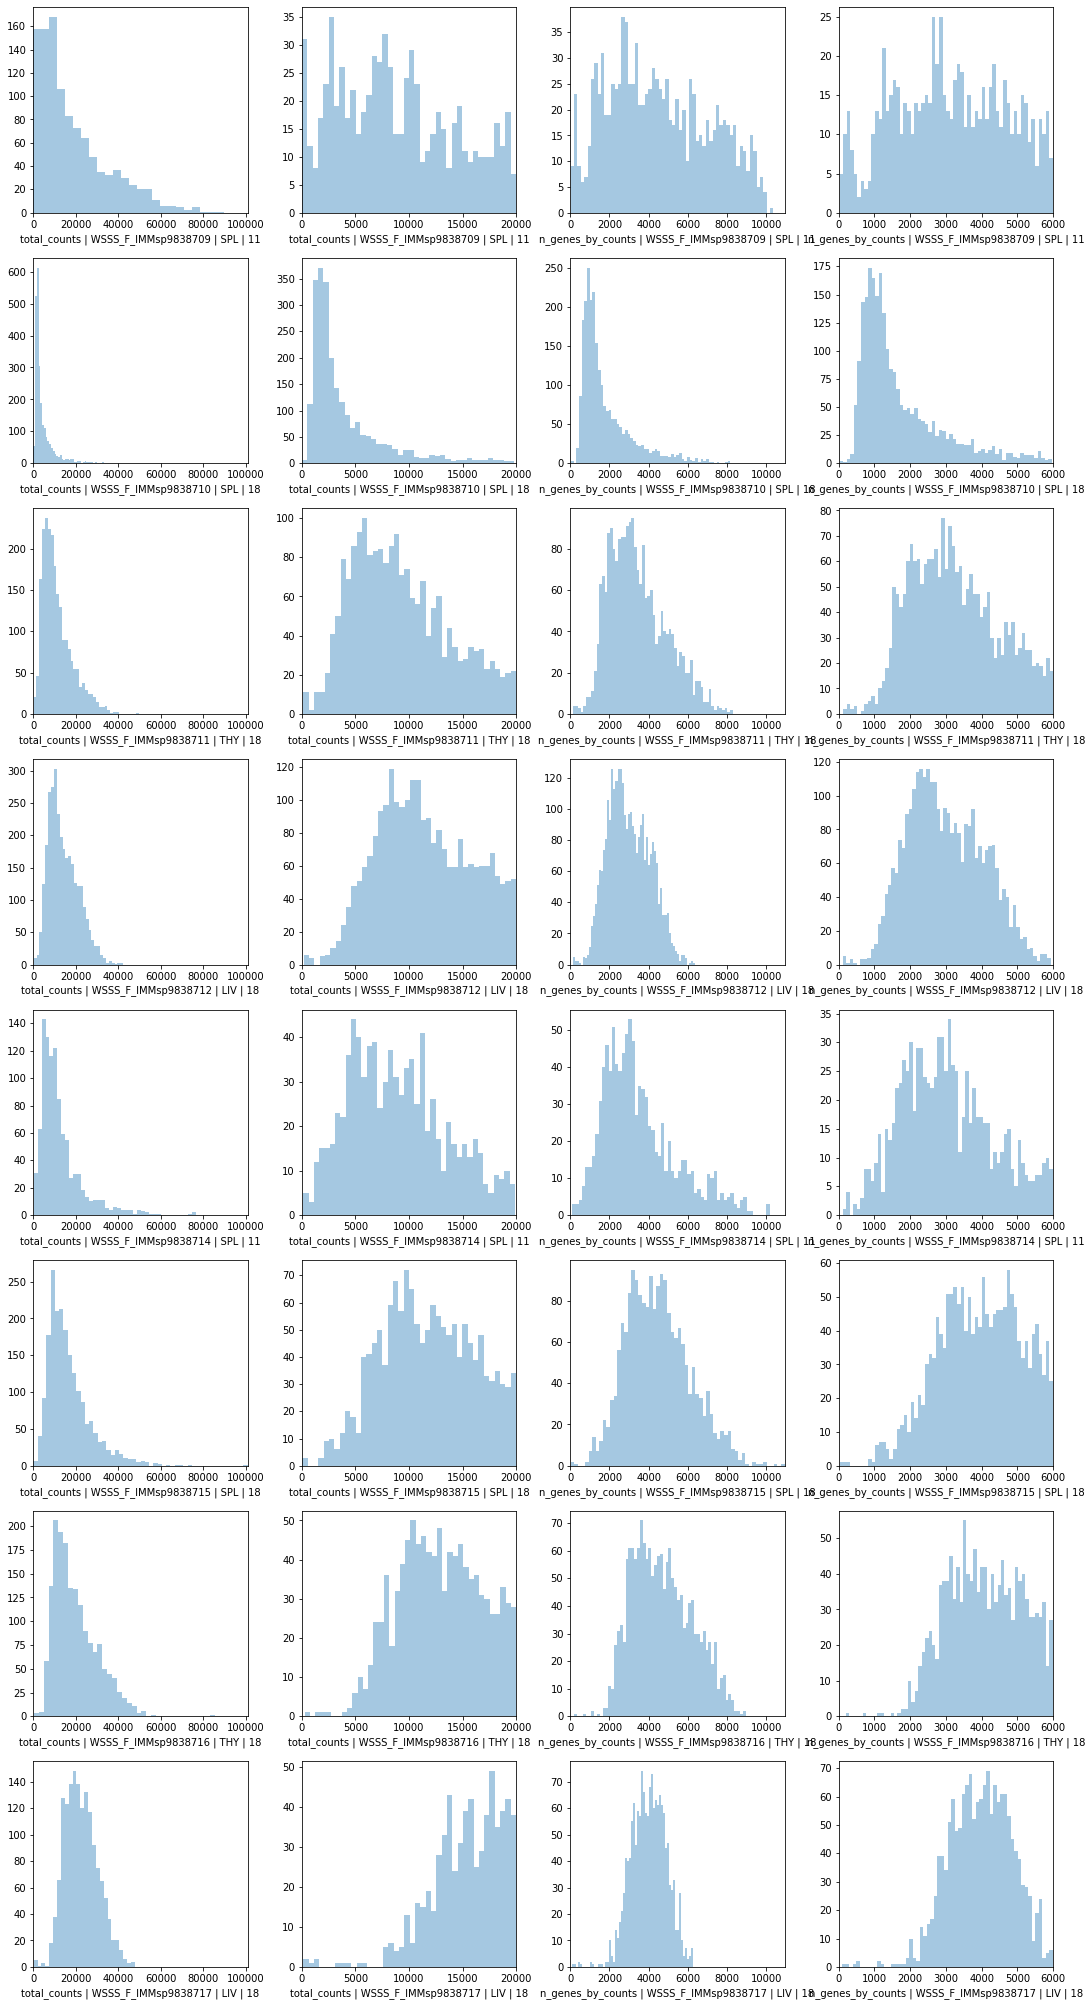

In [7]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
sample_col = 'sample'
organ_col = 'Organ'
age_col = 'Age_PCW'
for i, s in enumerate(adata.obs[sample_col].unique()):
    #fig.suptitle('Covariates for filtering')
    
    slide = select_slide(adata, s)
    s_lab = f'{slide.obs[sample_col][0]} | {slide.obs[organ_col][0]} | {slide.obs[age_col][0]}'
    sns.distplot(slide.obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s_lab}')
    
    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s_lab}')
    
    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s_lab}')
    
    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s_lab}')
    
plt.tight_layout()

## 2. Visualise Visium data in spatial 2D and UMAP coordinates <a name="2.-Visualise-Visium-data-in-spatial-2D-and-UMAP-coordinates"></a>

### Visualising data in spatial coordinates with scanpy

Next, we show how to plot these QC values over the histology image using standard scanpy tools

/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'img_id' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
Trying to set attribute `.obs` of view, copying.
... storing 'EXP_id' as categorica

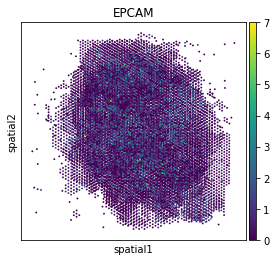

In [8]:
# scanpy tends to issue a lot of warning when plotting - so plot everything once to avoid repeating the same warnings
sc.pl.spatial(adata, 
              color=["EPCAM"], img_key=None,
              vmin=0, library_id=adata.obs['sample_id'][0], 
              gene_symbols='SYMBOL'
             )

In [9]:
adata.obs[['sample', 'Organ', 'Age_PCW']].drop_duplicates().sort_values('Organ')

,sample,Organ,Age_PCW
spot_id,,,
spaceranger130_count_36654_WSSS_F_IMMsp9838712_GRCh38-2020-A_AAACAAGTATCTCCCA-1,WSSS_F_IMMsp9838712,LIV,18
spaceranger130_count_36811_WSSS_F_IMMsp9838717_GRCh38-2020-A_AAACAAGTATCTCCCA-1,WSSS_F_IMMsp9838717,LIV,18
spaceranger130_count_36654_WSSS_F_IMMsp9838709_GRCh38-2020-A_AAACAAGTATCTCCCA-1,WSSS_F_IMMsp9838709,SPL,11
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAAGTATCTCCCA-1,WSSS_F_IMMsp9838710,SPL,18
spaceranger130_count_36811_WSSS_F_IMMsp9838714_GRCh38-2020-A_AAACAGCTTTCAGAAG-1,WSSS_F_IMMsp9838714,SPL,11
spaceranger130_count_36811_WSSS_F_IMMsp9838715_GRCh38-2020-A_AAACCGGGTAGGTACC-1,WSSS_F_IMMsp9838715,SPL,18
spaceranger130_count_36654_WSSS_F_IMMsp9838711_GRCh38-2020-A_AAACAAGTATCTCCCA-1,WSSS_F_IMMsp9838711,THY,18
spaceranger130_count_36811_WSSS_F_IMMsp9838716_GRCh38-2020-A_AAACAGCTTTCAGAAG-1,WSSS_F_IMMsp9838716,THY,18


/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'is_tissue' as categorical


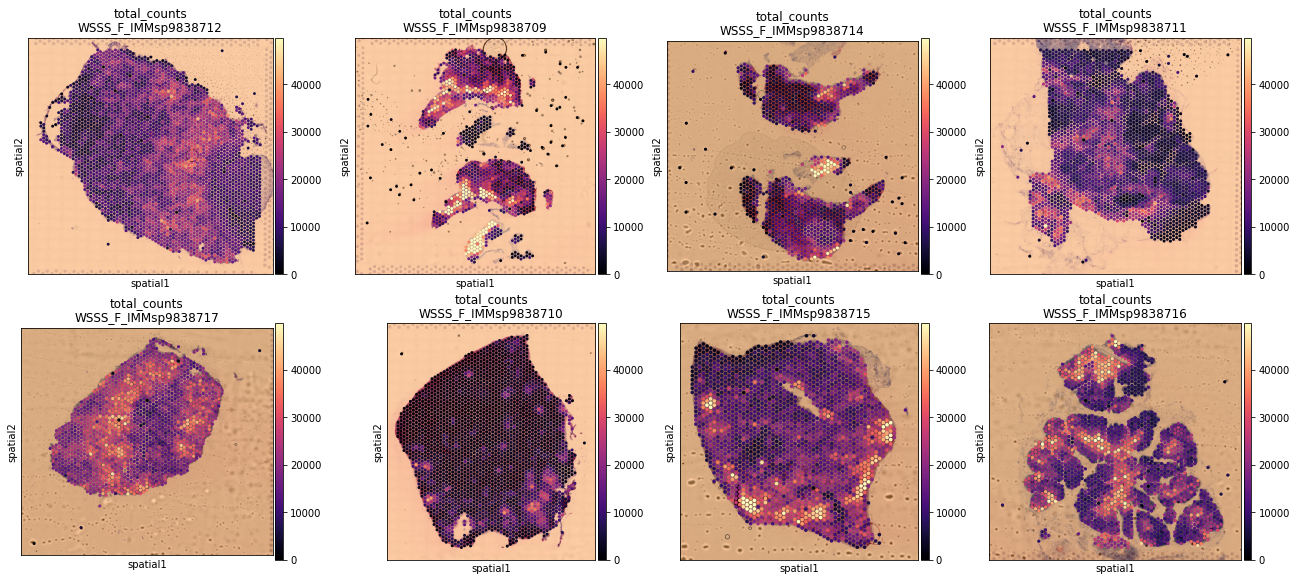

In [10]:
def plot_spatial_per_cell_type(adata, 
                                   cell_type='total_counts',
                                   samples=['WSSS_F_IMMsp9838712', 'WSSS_F_IMMsp9838717', 
                                            'WSSS_F_IMMsp9838709', 'WSSS_F_IMMsp9838710', 
                                            'WSSS_F_IMMsp9838714', 'WSSS_F_IMMsp9838715', 
                                            'WSSS_F_IMMsp9838711', 'WSSS_F_IMMsp9838716'],
                                  ncol=4, prefix=''):
        n_samples = len(samples)
        nrow = int(np.ceil(n_samples / ncol))
        fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8))
        if nrow == 1:
            axs = axs.reshape((1, ncol))

        col_name = f'{prefix}{cell_type}'
        vmax = np.quantile(adata.obs[col_name].values, 0.992)
        adata.obs[cell_type] = adata.obs[col_name].copy()

        from itertools import chain
        ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))

        for i, s in enumerate(samples):
            sp_data_s = select_slide(adata, s, s_col='sample')
            sc.pl.spatial(sp_data_s, cmap='magma',
                          color=cell_type, 
                          size=1.3, img_key='hires', alpha_img=1,
                          vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                                )
            axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)

        fig.tight_layout(pad=0.5)

        return fig
    
plot_spatial_per_cell_type(adata, cell_type='total_counts');

### Construct and examine UMAP of locations

Now we apply the standard scanpy processing pipeline to the spatial Visium data to show experiment to experiment variability in the data. Importatly, this workflow will show the extent of batch differences in your data (cell2location works on samples jointly, see below).

In this mouse brain dataset, only a few regions should be different between sections because we are using 2 samples from biological replicates sectioned at a slightly different location along the anterior-posterior axis in the mouse brain. We see general alighnment of locations from both experiments and some mismatches, but as you will see in the downstream analysis notebook most of the differences between experiments here come from batch effect, which cell2location can account for.

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


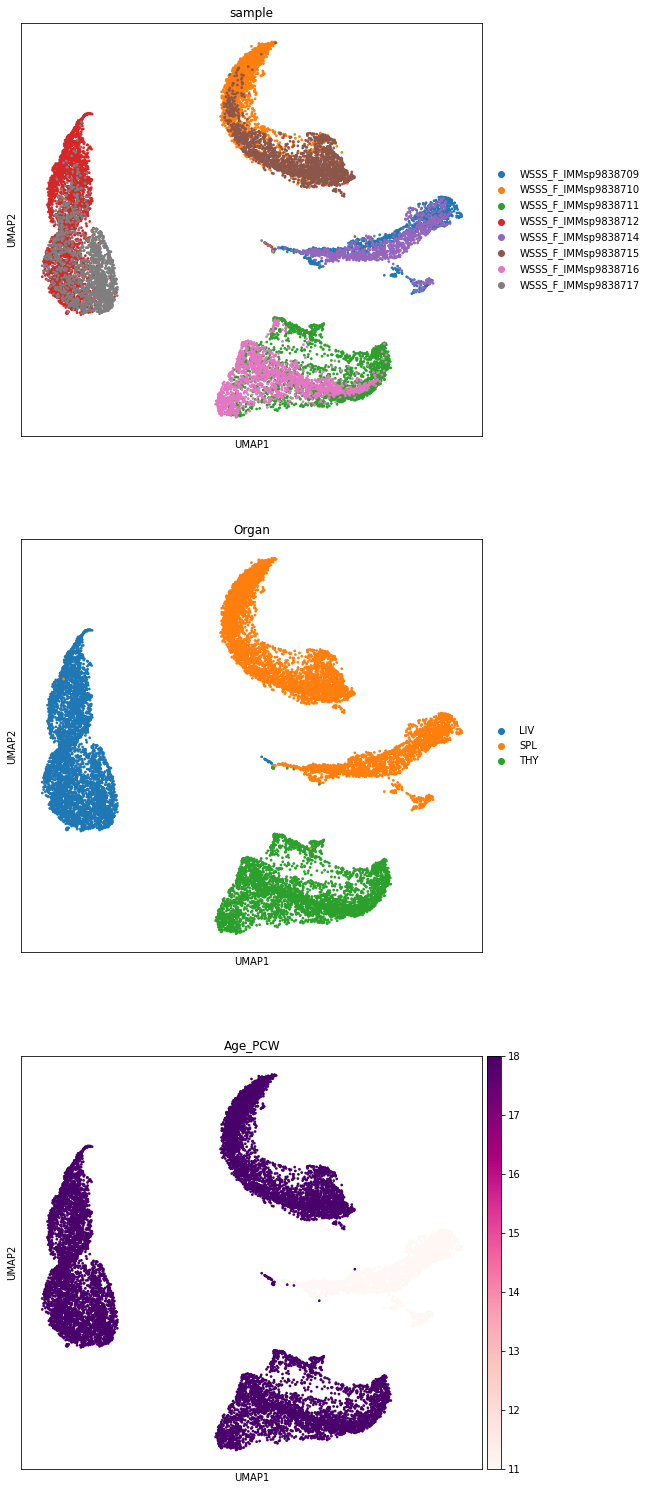

In [11]:
adata_vis_plt = adata.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():
    
    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)
    
    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True
    
# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample', 'Organ', 'Age_PCW'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

## 3. Load reference cell type signature from snRNA-seq data and show UMAP of cells <a name="3.-Load-reference-cell-type-signature-from-snRNA-seq-data-and-show-UMAP-of-cells"></a>

Next, we load the pre-processed snRNAseq reference anndata object that contains estimated expression signatures of reference cell types (see notebook 1/3).

In [12]:
## snRNAseq reference (raw counts)
adata_ref = sc.read(f'{reg_path}sc.h5ad')

In [13]:
umap = np.load('/nfs/team205/ed6/data/Fetal_immune/scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.scVI_out.UMAP.npy')
umap_cell_names = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.scVI_out.obs_names.csv')
umap_df = pd.DataFrame(umap, index=umap_cell_names['0'])
adata_ref.obsm['X_umap'] = umap_df.loc[adata_ref.obs_names].values

Export reference expression signatures of cell types:

In [14]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.index = adata_ref.var['GeneID'][inf_aver.index].values
inf_aver.iloc[0:5, 0:5]

,ABT(ENTRY),B1,BM_CD14_MONO,CD4+T,CD8+T
ENSG00000000003,0.034586,0.001682,0.001149,0.023253,0.047649
ENSG00000000005,0.000151,0.000206,0.001147,0.000128,0.000146
ENSG00000000419,0.153637,0.324845,0.171794,0.212223,0.242142
ENSG00000000457,0.032037,0.069242,0.025486,0.059139,0.056945
ENSG00000000460,0.004366,0.046712,0.008530,0.009873,0.017440


Quick look at the cell type composition in our reference data in UMAP coordinates (UMAP representation was generated using a standard scanpy workflow, see notebook 1/3).

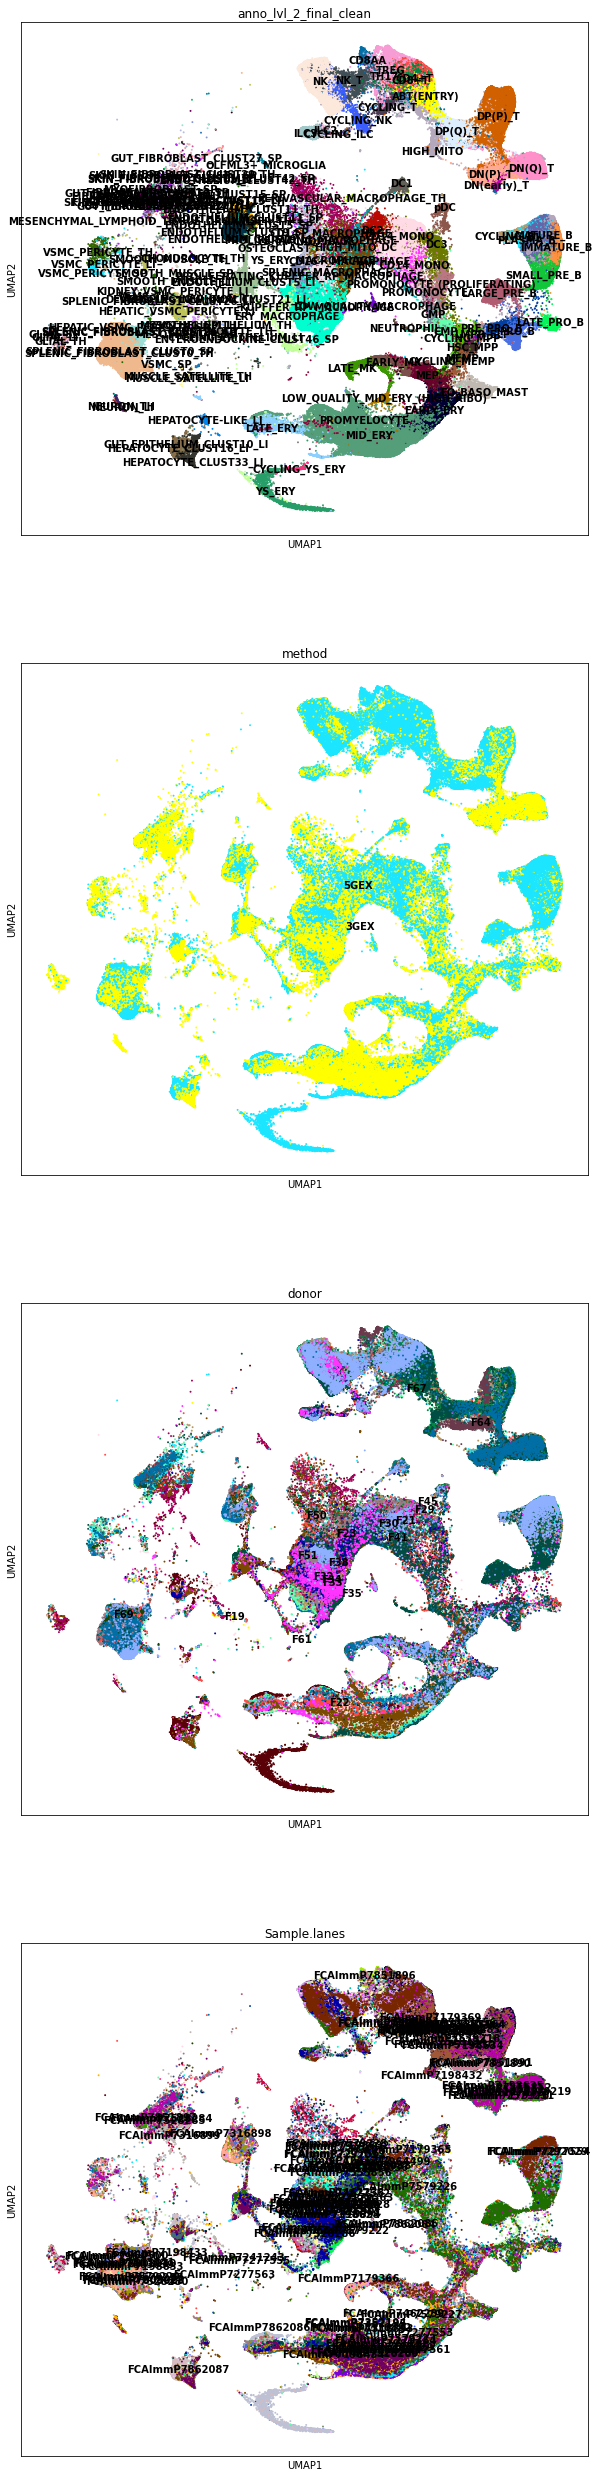

In [15]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_ref, color=['anno_lvl_2_final_clean', 'method', 'donor', 'Sample.lanes'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               palette = sc.pl.palettes.default_102 + sc.pl.palettes.zeileis_28 + sc.pl.palettes.vega_20_scanpy,
               legend_fontsize=10)

In [16]:
# find shared genes and subset both anndata and reference signatures
adata_vis = adata.copy()
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 15115 cells, 15175 vars, 8        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 15115 │
│             Vars             │ 15175 │
│            Labels            │   1   │
│           Batches            │   8   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                         Batch Categories                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ WSSS_F_IMMsp9838709 │          0          │
│                     │ WSSS_F_IMMsp9838710 │          1          │
│                     │ WSSS_F_IMMsp9838711 │          2          │
│                     │ WSSS_F_IMMsp9838712 │          3          │
│                     │ WSSS_F_IMMsp9838714 │          4          │
│                     │ WSSS_F_IMMsp9838715 │          5          │
│                     │ WSSS_F_IMMsp9838716 │          6          │
│                     │ WSSS_F_IMMsp9838717 │          7          │
└─────────────────────┴─────────────────────┴─────────────────────┘

In [17]:
alphas = [20]

for alpha in alphas:
    # create and train the model
    scvi_run_name = f'{run_name_global}_alphatest{alpha}'
    print(scvi_run_name)
    import pyro
    mod = cell2location.models.Cell2location(
        adata_vis, cell_state_df=inf_aver, 
        amortised=False,
        N_cells_per_location=30,
        detection_alpha=alpha,
        #detection_hyp_prior={"alpha": alpha, "mean_alpha": 10.0},
    ) 

    mod.train(max_epochs=30000, 
              batch_size=None, 
              train_size=1,
              #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
              plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
              use_gpu=True)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': int(adata_vis.n_obs), 'use_gpu': True}
    )

    # Save model
    mod.save(f"{scvi_run_name}", overwrite=True)
    # can be loaded later like this:
    # mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

    # Save anndata object with results
    adata_vis.obs['Age_PCW'] = adata_vis.obs['Age_PCW'].astype(str)
    adata_vis.obs['is_tissue'] = adata_vis.obs['is_tissue'].astype(str)
    adata_file = f"{scvi_run_name}/sp.h5ad"
    adata_vis.write(adata_file)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(5000)
    plt.savefig(f"{scvi_run_name}/training_ELBO_history_minus5k.png",
                bbox_inches='tight')
    plt.close()
    mod.plot_history(0)
    plt.savefig(f"{scvi_run_name}/training_ELBO_history_all.png",
                bbox_inches='tight')
    plt.close()
       
    # Examine reconstruction accuracy to assess if there are any issues with mapping
    # the plot should be roughly diagonal, strong deviations will signal problems
    mod.plot_QC()
    plt.savefig(f"{scvi_run_name}/reconstruction_accuracy_histogram.png",
                bbox_inches='tight')
    plt.close()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

    fig_dir = f"{scvi_run_name}/spatial/"
    import os
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    adata_vis.obs['total_cell_abundance'] = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()
    fig = plot_spatial_per_cell_type(adata_vis, cell_type='total_cell_abundance', prefix='');
    fig.savefig(f"{fig_dir}total_cell_abundance.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    adata_vis.obs['detection_y_s'] = adata_vis.uns['mod']['post_sample_q05']['detection_y_s']
    fig = plot_spatial_per_cell_type(adata_vis, cell_type='detection_y_s', prefix='');
    fig.savefig(f"{fig_dir}detection_y_s.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    fig = plot_spatial_per_cell_type(adata_vis, cell_type='total_counts', prefix='');
    fig.savefig(f"{fig_dir}total_RNA_counts.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    from re import sub
    import os
    for c in adata_vis.uns['mod']['factor_names']:
        fig = plot_spatial_per_cell_type(adata_vis, cell_type=c)
        fig_dir = f"{scvi_run_name}/spatial/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig_dir = f"{scvi_run_name}/spatial/per_cell_type/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig.savefig(f"{fig_dir}W_cell_abundance_q05_{sub('/', '_', c)}.png",
                    bbox_inches='tight')
        fig.clear()
        plt.close(fig)

    f"{scvi_run_name}/spatial/per_cell_type/"

    with mpl.rc_context({"axes.facecolor": "black"}):
        clust_names = adata_vis.uns['mod']['factor_names']

        for s in adata_vis.obs['sample'].unique():

            s_ind = adata_vis.obs['sample'] == s
            s_keys = list(adata_vis.uns['spatial'].keys())
            s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

            fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                                color=clust_names, ncols=5, library_id=s_spatial,
                                size=1.3, img_key='hires', alpha_img=1,
                                vmin=0, vmax='p99.2',
                                return_fig=True, show=False)

            fig_dir = f"{scvi_run_name}/spatial/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)
            fig_dir = f"{scvi_run_name}/spatial/per_sample/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)

            plt.savefig(f"{fig_dir}W_cell_abundance_q05_{s}.png",
                        bbox_inches='tight')
            plt.close()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

    # look at the total cell abundance for each experiment
    with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                         'figure.figsize': [5, 15]}):
        for i, n in enumerate(adata_vis.obs['sample'].unique()):
            plt.subplot(len(adata_vis.obs['sample'].unique()), 1, i+1)
            total_cell_abundance = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()
            total_cell_abundance_ = total_cell_abundance[adata_vis.obs['sample'] == n]
            plt.hist(total_cell_abundance_, bins=100);
            plt.title(n)
            plt.xlabel(r'Total cell abundance ($sum_f w_sf$) for each experiment')
            plt.xlim(0, total_cell_abundance.max())
        plt.savefig(f"{scvi_run_name}/total_cell_abundance.png",
                    bbox_inches='tight')
        plt.close()
     

/nfs/team205/vk7/sanger_projects/collaborations/pan_fetal_immune_mapping/results/spatial_mapping_LI_TH_SP_ref_alphatest20


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:47<00:00, 20.96it/s]


/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Age_PCW' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'is_tissue' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/cell2loc_env2/lib/python3.9/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

## Run tissue zone analysis

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(10, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{scvi_run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_15115locations_136factors
### Analysis name: CoLocatedGroupsSklearnNMF_21combina

In [ ]:
alphas = [200]

for alpha in alphas:
    # create and train the model
    scvi_run_name = f'{run_name_global}_alphatest{alpha}'
    print(scvi_run_name)
    import pyro
    mod = cell2location.models.Cell2location(
        adata_vis, cell_state_df=inf_aver, 
        amortised=False,
        N_cells_per_location=30,
        detection_alpha=alpha,
        #detection_hyp_prior={"alpha": alpha, "mean_alpha": 10.0},
    ) 

    mod.train(max_epochs=30000, 
              batch_size=None, 
              train_size=1,
              #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
              plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
              use_gpu=True)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': int(adata_vis.n_obs), 'use_gpu': True}
    )

    # Save model
    mod.save(f"{scvi_run_name}", overwrite=True)
    # can be loaded later like this:
    # mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

    # Save anndata object with results
    adata_vis.obs['Age_PCW'] = adata_vis.obs['Age_PCW'].astype(str)
    adata_vis.obs['is_tissue'] = adata_vis.obs['is_tissue'].astype(str)
    adata_file = f"{scvi_run_name}/sp.h5ad"
    adata_vis.write(adata_file)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(5000)
    plt.savefig(f"{scvi_run_name}/training_ELBO_history_minus5k.png",
                bbox_inches='tight')
    plt.close()
    mod.plot_history(0)
    plt.savefig(f"{scvi_run_name}/training_ELBO_history_all.png",
                bbox_inches='tight')
    plt.close()
       
    # Examine reconstruction accuracy to assess if there are any issues with mapping
    # the plot should be roughly diagonal, strong deviations will signal problems
    mod.plot_QC()
    plt.savefig(f"{scvi_run_name}/reconstruction_accuracy_histogram.png",
                bbox_inches='tight')
    plt.close()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

    fig_dir = f"{scvi_run_name}/spatial/"
    import os
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    adata_vis.obs['total_cell_abundance'] = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()
    fig = plot_spatial_per_cell_type(adata_vis, cell_type='total_cell_abundance', prefix='');
    fig.savefig(f"{fig_dir}total_cell_abundance.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    adata_vis.obs['detection_y_s'] = adata_vis.uns['mod']['post_sample_q05']['detection_y_s']
    fig = plot_spatial_per_cell_type(adata_vis, cell_type='detection_y_s', prefix='');
    fig.savefig(f"{fig_dir}detection_y_s.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    fig = plot_spatial_per_cell_type(adata_vis, cell_type='total_counts', prefix='');
    fig.savefig(f"{fig_dir}total_RNA_counts.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)

    from re import sub
    import os
    for c in adata_vis.uns['mod']['factor_names']:
        fig = plot_spatial_per_cell_type(adata_vis, cell_type=c)
        fig_dir = f"{scvi_run_name}/spatial/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig_dir = f"{scvi_run_name}/spatial/per_cell_type/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig.savefig(f"{fig_dir}W_cell_abundance_q05_{sub('/', '_', c)}.png",
                    bbox_inches='tight')
        fig.clear()
        plt.close(fig)

    f"{scvi_run_name}/spatial/per_cell_type/"

    with mpl.rc_context({"axes.facecolor": "black"}):
        clust_names = adata_vis.uns['mod']['factor_names']

        for s in adata_vis.obs['sample'].unique():

            s_ind = adata_vis.obs['sample'] == s
            s_keys = list(adata_vis.uns['spatial'].keys())
            s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

            fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                                color=clust_names, ncols=5, library_id=s_spatial,
                                size=1.3, img_key='hires', alpha_img=1,
                                vmin=0, vmax='p99.2',
                                return_fig=True, show=False)

            fig_dir = f"{scvi_run_name}/spatial/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)
            fig_dir = f"{scvi_run_name}/spatial/per_sample/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)

            plt.savefig(f"{fig_dir}W_cell_abundance_q05_{s}.png",
                        bbox_inches='tight')
            plt.close()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

    # look at the total cell abundance for each experiment
    with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                         'figure.figsize': [5, 15]}):
        for i, n in enumerate(adata_vis.obs['sample'].unique()):
            plt.subplot(len(adata_vis.obs['sample'].unique()), 1, i+1)
            total_cell_abundance = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()
            total_cell_abundance_ = total_cell_abundance[adata_vis.obs['sample'] == n]
            plt.hist(total_cell_abundance_, bins=100);
            plt.title(n)
            plt.xlabel(r'Total cell abundance ($sum_f w_sf$) for each experiment')
            plt.xlim(0, total_cell_abundance.max())
        plt.savefig(f"{scvi_run_name}/total_cell_abundance.png",
                    bbox_inches='tight')
        plt.close()
     

## Run tissue zone analysis

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(10, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{scvi_run_name}/CoLocatedComb/'}
)

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass